In [1]:
import pickle as pk
import matplotlib.pyplot as plt
import numpy as np
import torch

from torch.utils.data import DataLoader

from rml import training
from rml import utils
from rml.utils import plotting

from mlp import audio
from mlp import normalization
from mlp import utils as mlp
from mlp.dataset import WAVAudioDS, PolarPreprocessing

from multiprocessing import Pool

from models.unet import *

In [2]:
%matplotlib inline

In [3]:
utils.utils.set_is_notebook(True)
device = utils.utils.device

In [4]:
fs = 48000
bs = 32
stroke_width = 10
patch_width = 128
patch_height = 64

In [5]:
stroke_mask = mlp.build_stroke_purge_mask(patch_width, patch_height, stroke_width, fs)
stroke_mask_not = ~stroke_mask

purge_mask = stroke_mask.float()
keep_mask = stroke_mask_not.float()

In [6]:
files_train = pk.load(open('../files/train.pk', 'rb'))[:1]
files_test = pk.load(open('../files/test.pk', 'rb'))[:1]
files_valid = pk.load(open('../files/valid.pk', 'rb'))[:1]

In [7]:
preprocess = PolarPreprocessing(
    normalization.norm_mag, 
    normalization.norm_phase, 
    patch_width, 
    patch_height
)

with Pool(8) as p:
    ds_train = WAVAudioDS(files_train, lambda x: x * purge_mask, preprocess, patch_width, p) # just using a fraction of our data
    ds_test = WAVAudioDS(files_test, lambda x: x * purge_mask, preprocess, patch_width, p)

dl_train = DataLoader(ds_train, batch_size=bs, num_workers=4, shuffle=True)
dl_test = DataLoader(ds_test, batch_size=bs, num_workers=4, shuffle=False)

100%|██████████| 1/1 [00:00<00:00, 650.38it/s]


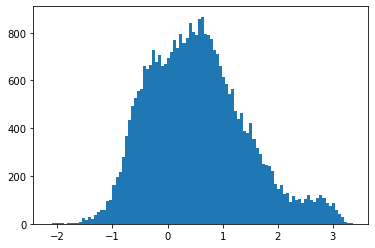

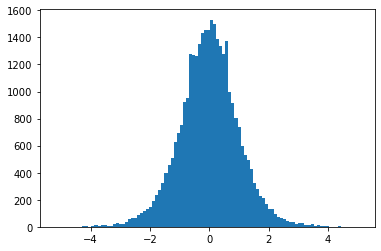

In [8]:
# the data has a really nice distribution now :)
plt.hist(ds_train.stroke[0].view(-1), bins=100)
plt.show()

plt.hist(ds_train.stroke[1].view(-1), bins=100)
plt.show()

In [9]:
mse = torch.nn.MSELoss()
loss_mask =  stroke_mask_not.float().to(device)

def MSEGapLoss(pred, targ):
    return mse(pred * loss_mask, targ * loss_mask)

In [10]:
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        self.inc = inconv(2, 64)
        self.down1 = down(64, 128)
        self.down2 = down(128, 256)
        self.down3 = down(256, 512)
        self.down4 = down(512, 512)
        self.up1 = up(1024, 256)
        self.up2 = up(512, 128)
        self.up3 = up(256, 64)
        self.up4 = up(128, 64)
        self.outc = outconv(64, 2)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        x = self.outc(x)
        return x
    
model = UNet().to(device)
optim = torch.optim.Adam(model.parameters())

In [11]:
train_data = training.optimize(100, model, optim, MSEGapLoss, dl_train, dl_test) 


Epoch: 0



Train Cost: 65307.21484375
Test Cost: 65183.453125

Epoch: 1



Train Cost: 34115.84765625
Test Cost: 63606.4453125

Epoch: 2



Train Cost: 27811.86328125
Test Cost: 60310.4375

Epoch: 3



Train Cost: 14383.7138671875
Test Cost: 56041.0

Epoch: 4



Train Cost: 11527.1845703125
Test Cost: 52365.5078125

Epoch: 5



Train Cost: 10552.638671875
Test Cost: 49040.97265625

Epoch: 6



Train Cost: 8192.7275390625
Test Cost: 44193.953125

Epoch: 7



Train Cost: 7914.30810546875
Test Cost: 39273.8671875

Epoch: 8



Train Cost: 6359.15185546875
Test Cost: 35176.66796875

Epoch: 9



Train Cost: 5834.88671875
Test Cost: 32815.25

Epoch: 10



Train Cost: 5725.8818359375
Test Cost: 29638.548828125

Epoch: 11



Train Cost: 5147.29150390625
Test Cost: 25636.23046875

Epoch: 12



Train Cost: 4910.333984375
Test Cost: 21441.140625

Epoch: 13



Train Cost: 4780.08935546875
Test Cost: 18515.806640625

Epoch: 14



Train Cost: 4331.9111328125
Test Cost: 17161.724609375

Epoch: 15



Train Cost: 4095.356689453125
Test Cost: 15682.251953125

Epoch: 16



Train Cost: 4002.140869140625
Test Cost: 13320.951171875

Epoch: 17



Train Cost: 3813.066650390625
Test Cost: 10978.1474609375

Epoch: 18



Train Cost: 4137.3544921875
Test Cost: 9310.96875

Epoch: 19



Train Cost: 4105.21826171875
Test Cost: 8367.869140625

Epoch: 20



Train Cost: 3853.198974609375
Test Cost: 7777.78515625

Epoch: 21



Train Cost: 3329.463134765625
Test Cost: 7699.580078125

Epoch: 22



Train Cost: 3290.615234375
Test Cost: 6922.7587890625

Epoch: 23



Train Cost: 3511.56396484375
Test Cost: 5845.57421875

Epoch: 24



Train Cost: 3341.436279296875
Test Cost: 5542.58154296875

Epoch: 25



Train Cost: 2978.310546875
Test Cost: 5515.26806640625

Epoch: 26



Train Cost: 3750.333984375
Test Cost: 4680.79345703125

Epoch: 27



Train Cost: 3160.34521484375
Test Cost: 4164.91845703125

Epoch: 28



Train Cost: 2825.49560546875
Test Cost: 4074.64501953125

Epoch: 29



Train Cost: 2831.132080078125
Test Cost: 3716.732421875

Epoch: 30



Train Cost: 3126.889892578125
Test Cost: 3273.76025390625

Epoch: 31



Train Cost: 2960.889892578125
Test Cost: 3339.920654296875

Epoch: 32



Train Cost: 2896.53857421875
Test Cost: 3208.01513671875

Epoch: 33



Train Cost: 2691.33544921875
Test Cost: 3301.857421875

Epoch: 34



Train Cost: 2631.664794921875
Test Cost: 3423.354248046875

Epoch: 35



Train Cost: 2659.374267578125
Test Cost: 3277.901123046875

Epoch: 36



Train Cost: 2614.564453125
Test Cost: 3062.790283203125

Epoch: 37



Train Cost: 2766.56298828125
Test Cost: 3067.801513671875

Epoch: 38



Train Cost: 2709.75244140625
Test Cost: 3153.09375

Epoch: 39



Train Cost: 2486.69091796875
Test Cost: 2994.992919921875

Epoch: 40



Train Cost: 2448.6123046875
Test Cost: 2980.697265625

Epoch: 41



Train Cost: 2338.053466796875
Test Cost: 2965.2314453125

Epoch: 42



Train Cost: 2352.352783203125
Test Cost: 2938.022216796875

Epoch: 43



Train Cost: 2471.74853515625
Test Cost: 2790.840087890625

Epoch: 44



Train Cost: 2304.850830078125
Test Cost: 2658.835693359375

Epoch: 45



Train Cost: 2275.25
Test Cost: 2671.917724609375

Epoch: 46



Train Cost: 2192.40576171875
Test Cost: 2756.308349609375

Epoch: 47



Train Cost: 2364.571533203125
Test Cost: 2428.86083984375

Epoch: 48



Train Cost: 2212.944580078125
Test Cost: 2557.18994140625

Epoch: 49



Train Cost: 2159.439453125
Test Cost: 2705.762939453125

Epoch: 50



Train Cost: 2152.52490234375
Test Cost: 2343.583740234375

Epoch: 51



Train Cost: 2105.775146484375
Test Cost: 2445.736083984375

Epoch: 52



Train Cost: 2026.0859375
Test Cost: 2735.657958984375

Epoch: 53



Train Cost: 2047.0587158203125
Test Cost: 2611.84130859375

Epoch: 54



Train Cost: 1986.988525390625
Test Cost: 2397.416259765625

Epoch: 55



Train Cost: 1985.6204833984375
Test Cost: 2418.22412109375

Epoch: 56



Train Cost: 1978.2677001953125
Test Cost: 2405.7099609375

Epoch: 57



Train Cost: 1937.0379638671875
Test Cost: 2194.5107421875

Epoch: 58



Train Cost: 2025.4227294921875
Test Cost: 2156.409423828125

Epoch: 59



Train Cost: 1817.669921875
Test Cost: 2171.990478515625

Epoch: 60



Train Cost: 2152.05615234375
Test Cost: 2093.570556640625

Epoch: 61



Train Cost: 1916.343017578125
Test Cost: 2086.0244140625

Epoch: 62



Train Cost: 2027.5120849609375
Test Cost: 2168.470703125

Epoch: 63



Train Cost: 1893.1021728515625
Test Cost: 2099.87109375

Epoch: 64



Train Cost: 1841.40234375
Test Cost: 2168.81787109375

Epoch: 65



Train Cost: 1903.12060546875
Test Cost: 2325.05224609375

Epoch: 66



Train Cost: 1728.9107666015625
Test Cost: 2341.759033203125

Epoch: 67



Train Cost: 1729.8768310546875
Test Cost: 2154.5556640625

Epoch: 68



Train Cost: 1937.4613037109375
Test Cost: 1967.1116943359375

Epoch: 69



Train Cost: 1723.14404296875
Test Cost: 2039.7117919921875

Epoch: 70



Train Cost: 1831.4681396484375
Test Cost: 1993.662109375

Epoch: 71



Train Cost: 1760.2628173828125
Test Cost: 1884.9705810546875

Epoch: 72



Train Cost: 1726.8953857421875
Test Cost: 1873.9654541015625

Epoch: 73



Train Cost: 1701.417236328125
Test Cost: 1933.7259521484375

Epoch: 74



Train Cost: 1689.4110107421875
Test Cost: 1941.2247314453125

Epoch: 75



Train Cost: 1647.8077392578125
Test Cost: 1907.2532958984375

Epoch: 76



Train Cost: 1766.4404296875
Test Cost: 1903.11376953125

Epoch: 77



Train Cost: 1592.94580078125
Test Cost: 1965.906982421875

Epoch: 78



Train Cost: 1664.758056640625
Test Cost: 1959.14697265625

Epoch: 79



Train Cost: 1815.83544921875
Test Cost: 1910.2828369140625

Epoch: 80



Train Cost: 1821.072021484375
Test Cost: 1846.111572265625

Epoch: 81



Train Cost: 1568.5341796875
Test Cost: 1818.7694091796875

Epoch: 82



Train Cost: 1783.8126220703125
Test Cost: 1818.2828369140625

Epoch: 83



Train Cost: 1594.6480712890625
Test Cost: 1863.9019775390625

Epoch: 84



Train Cost: 1589.070068359375
Test Cost: 1881.459716796875

Epoch: 85



Train Cost: 1597.1131591796875
Test Cost: 1866.351806640625

Epoch: 86



Train Cost: 1721.70556640625
Test Cost: 1858.155517578125

Epoch: 87



Train Cost: 1528.275634765625
Test Cost: 1787.37548828125

Epoch: 88



Train Cost: 1557.54931640625
Test Cost: 1772.7684326171875

Epoch: 89



Train Cost: 1535.2159423828125
Test Cost: 1775.9847412109375

Epoch: 90



Train Cost: 1469.6805419921875
Test Cost: 1817.2432861328125

Epoch: 91



Train Cost: 1498.01513671875
Test Cost: 1783.3131103515625

Epoch: 92



Train Cost: 1414.67431640625
Test Cost: 1755.92626953125

Epoch: 93



Train Cost: 1405.38037109375
Test Cost: 1746.9036865234375

Epoch: 94



Train Cost: 1620.44677734375
Test Cost: 1773.273681640625

Epoch: 95



Train Cost: 1606.4244384765625
Test Cost: 1784.9935302734375

Epoch: 96



Train Cost: 1775.7806396484375
Test Cost: 1691.3504638671875

Epoch: 97



Train Cost: 1435.12353515625
Test Cost: 1664.590087890625

Epoch: 98



Train Cost: 1445.700927734375
Test Cost: 1832.8563232421875

Epoch: 99



Train Cost: 1683.4722900390625
Test Cost: 1707.9639892578125



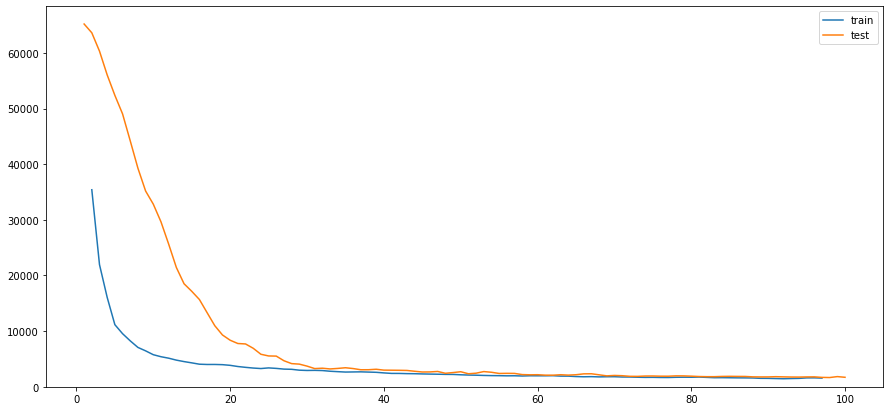

In [15]:
plotting.plot_train_data(train_data)
# plt.ylim(ymin=0.0125, ymax=0.014)

In [17]:
X_orig, y_orig = ds_test[0]

pred_orig = model(X_orig.unsqueeze(0).to(device)).squeeze(0)
pred_orig = X_orig.cpu() + loss_mask.cpu() * pred_orig.cpu()

y = WAVAudioDS.torch_to_freqs(y_orig, normalization.denorm_polar)
_, y_time = audio.istft(y, fs)

pred = WAVAudioDS.torch_to_freqs(pred_orig, normalization.denorm_polar)
_, pred_time = audio.istft(pred, fs)

X = WAVAudioDS.torch_to_freqs(X_orig, normalization.denorm_polar)
_, X_time = audio.istft(X, fs)

/home/hector/Code/MSc/MLP/mlp-final-fork/libraries/mlp/dataset.py:111: RuntimeWarning: invalid value encountered in multiply
  freqs = freqs[0] + freqs[1] * 1j


In [18]:
audio.play_audio(y_time, rate=fs)

In [19]:
audio.play_audio(pred_time, rate=fs)

In [20]:
audio.play_audio(X_time, rate=fs)

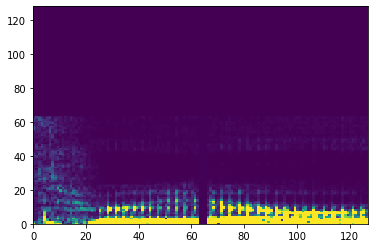

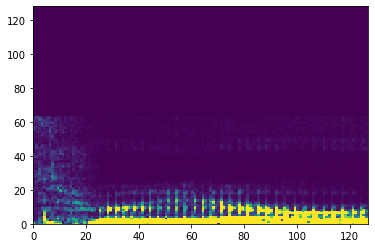

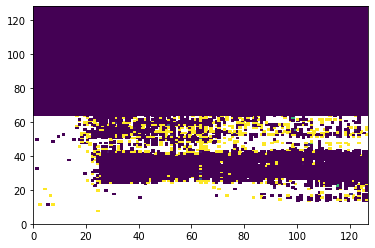

In [21]:
audio.show_spectra(X)
plt.show()

audio.show_spectra(y)
plt.show()

audio.show_spectra(pred)
plt.show()

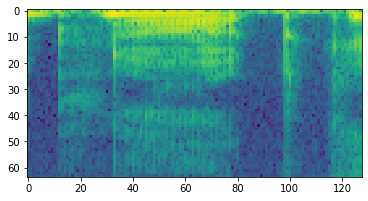

In [22]:
for i in range(1):
    plt.imshow(ds_train[i][1][0])
    plt.show()